In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
import keras.layers
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import BatchNormalization
from keras.regularizers import L1L2
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import tensorflow as tf

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
np.random.seed(0)
train, valid, test = pickle.load(open('dataset.pickle', 'rb'))
train = train.fillna(0)
test = test.fillna(0)

In [13]:
x_train = train[['raw_acc','proc_gyro','raw_magnet','watch_acceleration','watch_heading', 'location', 'location_quick_features', 'audio_naive', 'audio_properties', 'discrete', 'lf_measurements']]
y_train = train.iloc[:,-8:]
x_test = test[['raw_acc','proc_gyro','raw_magnet','watch_acceleration','watch_heading', 'location', 'location_quick_features', 'audio_naive', 'audio_properties', 'discrete', 'lf_measurements']]
y_test = np.asarray(test.iloc[:,-8:])

In [14]:
scaler = MinMaxScaler() #scale features between 0 and 1
x_train = scaler.fit_transform(x_train)
#x_train = np.asarray(x_train).reshape(x_train.shape[0], 1, x_train.shape[1])
x_test = scaler.fit_transform(x_test)
#x_test = np.asarray(x_test).reshape(x_test.shape[0], 1, x_test.shape[1])

In [25]:
model = Sequential()
#model.add(LSTM(500, input_shape=(x_train.shape[1], x_train.shape[2]), bias_regularizer=L1L2(l1=0.01, l2=0.01)))
#model.add(LSTM(500, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dense(2000, input_dim=x_train.shape[1], activation='relu'))
model.add(Dropout(0.2, noise_shape=None, seed=None))
model.add(BatchNormalization())
model.add(Dense(100, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
history = model.fit([x_train], batch_size=100, y=y_train, verbose=1, validation_split=0.25, 
          shuffle=True, epochs=20)

Train on 223329 samples, validate on 74444 samples
Epoch 1/20
223329/223329 [==============================] - 24s 106us/step - loss: 1.0250 - acc: 0.6236 - val_loss: 1.3593 - val_acc: 0.5220
Epoch 2/20
223329/223329 [==============================] - 23s 101us/step - loss: 0.9276 - acc: 0.6556 - val_loss: 1.2431 - val_acc: 0.5488
Epoch 3/20
223329/223329 [==============================] - 23s 101us/step - loss: 0.8804 - acc: 0.6737 - val_loss: 1.3414 - val_acc: 0.5398
Epoch 4/20
223329/223329 [==============================] - 24s 106us/step - loss: 0.8537 - acc: 0.6844 - val_loss: 1.2802 - val_acc: 0.5571
Epoch 5/20
223329/223329 [==============================] - 23s 104us/step - loss: 0.8375 - acc: 0.6908 - val_loss: 1.2905 - val_acc: 0.5501
Epoch 6/20
223329/223329 [==============================] - 23s 103us/step - loss: 0.8145 - acc: 0.7003 - val_loss: 1.3061 - val_acc: 0.5485
Epoch 7/20
223329/223329 [==============================] - 22s 98us/step - loss: 0.7986 - acc: 0.7073 

In [27]:
predicted = model.predict(x_test)
predicted = np.argmax(predicted, axis=1)
y_test_decode = np.argmax(y_test, axis=1)
print(accuracy_score(y_test_decode, predicted))

0.49584664536741213


Train: 0.716, Test: 0.496


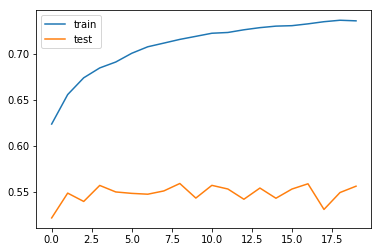

In [28]:
# evaluate the model
_, acc_train = model.evaluate(x_train, y_train, verbose=0)
_, acc_test = model.evaluate(x_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (acc_train, acc_test))
# learning curves of model accuracy
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show()

In [29]:
# save model
import os
dir_name = 'nn'
if not os.path.exists(dir_name):
    os.makedirs(dir_name)
filename = dir_name + '/2layers_crossval_20epoch.nn'
model.save(filename)
print('Saved %s' % filename)

Saved nn/2layers_crossval_20epoch.nn
